In [1]:
"""

Regression de Ridge (L2) par methode des moindres carres permettant la penalisation du surapprentissage.

Arguments :

    y : Variable d'interet (dimension : n x 1)
    x : matrice contenant nos variables explicatives (dimension : n x p)
    l : facteur qui permet de diminuer l'amplitude des coefficients de regression
    minY : borne inférieur appliquer sur les predictions
    maxY : borne supérieur appliquer sur les predictions
    
    ou,
        n : nombre d'observation
        p : nombre de variable explicative       
        

Retourne : 

    B = Matrices de nos coefficiants de regression (dimension (p+1) x 1)
    Y_estime = Nouvelles predictions avec les coefficiants B

"""

def ridge_regression(y,x,l,minY,maxY):
    
    # Nombre d'observations
    n = len(x)
    
    # Nombre de variable explicative
    p = len(x.T)
    
    # Colonne de 1
    Ones = np.array([np.ones(n)]).T
    
    # On l'emboite a notre matrice x
    x_withOne = np.concatenate((Ones,x),axis = 1)    
    
    # Matrice identite de taille p+1
    identi = np.identity(p+1) 
    identi[0][0] = 0 # on met un zero vis a vis le coeff b0 qui est l'ordonnee a l'origine
    identi = np.dot(l,identi)
    
    # On multiplie X par soi meme
    x2_withOne = np.dot(x_withOne.T,x_withOne)
    
    # On calcule la matrice de variance-covariance avec un biais de penalite
    C = np.linalg.inv(x2_withOne + identi)
    
    # On calcule les coefficients de regression
    B = np.dot(y,np.dot(x_withOne,C))
    
    # On calcule les predictions
    Y_estime = np.dot(x_withOne,B)
    
    # On borne nos prediction
    Y_estime_borne = Y_estime.clip(minY,maxY)
    
    return B, Y_estime_borne

In [2]:
"""

Fonction permettant de transformer une matrice pour que ses colonnes aient une moyenne = 0 et une variance = 1

Argument:
    dataset : le jeu de donnees a transformer
    
Retourne :
    dataset_std : le jeu de donnees transforme

"""
def scaler(dataset):
    
    # On calcule la moyenne pour chaque colonne
    u = np.array([np.mean(dataset, axis=0)])
    
    # On soustrait les colonnes du jeu de donnees par ses moyennes
    dataset_std = dataset - u
    
    # On calcule la variance pour chaque colonne
    sigma = np.array([np.std(dataset_std, axis=0)])
    
    # On divise les colonnes du jeu de donnees par ses variances
    dataset_std = dataset_std/sigma
    
    # Si contient des NaN cause par une division par 0 (si la variance etait de 0)
    if(np.isnan(dataset_std).any()):
        print("Colonne de variance = 0, contient des NaN") # On affiche le message d'erreur
        
    
    return dataset_std
    

In [3]:
"""

L'algorithme R2_prev implemente une validation croise sur l'ensemble du jeu de donnees fournis

Arguments:
    Y : La variable d'interet
    W : Notre estimation de la variable d'interet
    X : Nos variables explicatives
    


Retourne:

    R2_prev : Une mesure bornee entre [-inf, 1] qui represente le pouvoir predictif de nos estimations

"""

def R2_prev(Y,W,X):
    
    # On multiplie X par soi meme
    X2 = np.dot(X.T,X)  
    
    # The variance-covariance
    C = np.linalg.inv(X2)
    
    # Hat Matrix (X*B = H*Y)
    H = np.dot(np.dot(X,C),X.T)
    
    # We are only interested in the (i,i) values
    H = np.diagonal(H)
    
    # Mean of Y
    y_S = np.sum(Y)/float(len(Y))
    
    num = 0.0
    for i in range(len(Y)):
        num += ((Y[i] - W[i])/float(1 - H[i]))**2

    denom = 0.0
    for i in range(len(Y)):
        denom += (Y[i] - y_S)**2
    
    R2_prev = (1 - num/denom)
    
    return R2_prev
    

In [4]:
"""

Selon le document MTH3302_CriteresProjet.pdf nous sommes evalues par notre root mean squared error (RMSE).
On trouve ici son implementation.

Arguments :
    Y : La variable d'interet
    W : Notre estimation de la variable d'interet
    
    
Retourne:
    rmse : L'erreur moyenne de nos predictions

"""

def RMSE(Y,W):

    n = len(Y)

    total = 0.0
    for i in range(n):
        total += (Y[i] - W[i])**2
        
    rmse = total/float(n)
        
    return rmse

In [5]:
"""
--- Variable Qualitative -> Table Binaire --- 

Afin de traiter nos variables qualitatives, nous avons une fonction qui la tranforme en table binaire 
avec un one bit encoder. 

    Disons que la variable explicative peut prendre 4 valeurs {Bleu, Vert, Jaune, Rouge},
        
          ID        X1
        ----------------
          1        Bleu
          2        Bleu
          3        Vert
          4        Jaune
          5        Vert
          6        Rouge          
         ...
    
    Suite a un encodage en 1 bit notre variable explicative X1 devient,
    
          ID        Bleu        Vert        Jaune        Rouge
        -------------------------------------------------------
          1          1           0            0            0
          2          1           0            0            0
          3          0           1            0            0
          4          0           0            1            0
          5          0           1            0            0
          6          0           0            0            1
                                ...
                                

Nous nous basons sur la fonction get_dummies() de la librairie Panda pour faire ceci.


Arguments,

    trainSet : le jeu de donnees de training
    testSet : le jeu de donnees de test
    varName : la variable qualitative que nous souhaitons transformer en tableau binaire
    
    
Retourne, 
    trainSet_new : le jeu de donnees de training ou la variable qualitative a ete remplacee par un tableau binaire
    testSet_new : le jeu de donnees de test ou la variable qualitative a ete remplacee par un tableau binaire

"""

def qualiToBinary(trainSet, testSet, varName):
    
    # Genere la table binaire de la variable qualitative
    trainVar_binary = pd.get_dummies(trainSet[varName],prefix=varName)
    testVar_binary = pd.get_dummies(testSet[varName],prefix=varName)
    
    # On convertit nos tableaux binaires en Dataframe
    trainVar_binary = pd.DataFrame(trainVar_binary)
    testVar_binary = pd.DataFrame(testVar_binary)
    
    # On enleve la variable qualitative de nos jeux de donnees
    trainSet_new = trainSet.drop([varName], axis=1)
    testSet_new = testSet.drop([varName], axis=1)   

    # On ajoute les nouvelles colonnes a nos jeux de donnees
    trainSet_new = pd.concat([trainSet_new,trainVar_binary],axis=1)
    testSet_new = pd.concat([testSet_new,testVar_binary],axis=1)
    
    # On identifie les colonnes manquantes dans le jeu de donnees test
    missing_categories = set(trainSet_new) - set(testSet_new)

    # On ajoute ces colonnes manquantes avec une valeur par defaut de 0
    for c in missing_categories:
        testSet_new[c] = 0

    # On identifie les colonnes manquantes dans le jeu de donnees training
    missing_categories = set(testSet_new) - set(trainSet_new)

    # On ajoute ces colonnes manquantes avec une valeur par defaut de 0
    for c in missing_categories:
        trainSet_new[c] = 0


    # On aligne nos jeux de donnees pour que les memes colonnes soient aux memes endroits
    trainSet_new, testSet_new = trainSet_new.align(testSet_new, axis=1)
    
    # On retourne les jeux de donnees
    return trainSet_new, testSet_new

In [6]:
# traitement des données manquantes

strat_imputation = ["drop_na", "mean", "median", "most_frequent", "hot_deck", "cold_deck"]

def impute_data(data, nom_colonne, method = "drop_na"):
    """
    On remplace les valeurs manquantes dans la colonne sélectionnée suivant l'une des stratégie ci-dessous:
    - drop_na :  On supprime simplement les lignes avec des valeurs manquantes
    - moyenne/médiane/mode : on remplace les valeurs manquantes par la moyenne, médiane ou mode de la colonne respectivement
    - hot_deck : on cherche des données avec des caractéristiques similaires à la ligne avec la valeur manquante et
                  on lui donne une valeur aléatoire de celles-ci
    - cold_deck : on cherche des données avec des caractéristiques similaires à la ligne avec la valeur manquante et
                  on lui donne une valeur particulière parmi celles-ci

    
    retourne la base de données imputée
    """
    
    if method == "drop_na":
        return data.dropna(subset = [nom_colonne])
    
    if method == "mean" or method == "median" or method == "most_frequent":
        from sklearn.preprocessing import Imputer
        imputer = Imputer(strategy = method)
        imputed = data.copy()
        imputed[nom_colonne] = imputer.fit_transform(data[[nom_colonne]])
        return imputed
    
    if method == "hot_deck" :
        #on itère sur la colonne, et si on trouve une valeur manquante, on cherche toutes les observations avec les
        # ... mêmes valeurs de platform et genre ainsi qu'une valeur proche de other_sales. Puis on choisis une valeur
        # ... aléatoire parmi celles-ci pour imputer notre valeur manquante.
        imputed = data.copy()
        for i in range(1,len(imputed.values)):
            try:
                if np.isnan(imputed.at[i, nom_colonne]):
                    platform = imputed.at[i, 'Platform']
                    genre = imputed.at[i, 'Genre']
                    other_sales = imputed.at[i, 'Other_Sales']
                    A = imputed.loc[(imputed[nom_colonne].notna()) & (imputed['Platform'] == platform) & (imputed['Genre'] == genre) & (imputed['Other_Sales'] < other_sales + 0.1) & (imputed['Other_Sales'] > other_sales - 0.1)]
                    if len(A) == 0:
                        continue
                    else:
                        imputed.at[i, nom_colonne] = np.random.choice(A[nom_colonne])
            except:
                continue
        imputed = imputed.dropna(subset = [nom_colonne])
        return imputed
    
    if method == "cold_deck":
        #même méthode que pour le hot_deck, sauf que cette fois_ci on ne choisis pas aléatoirement pour ne pas
        #... ajouter de la variabilité au modèle. On choisit de manière déterministe, dans notre cas la première
        imputed = data.copy()
        for i in range(1,len(imputed.values)):
            if np.isnan(imputed.at[i, nom_colonne]):
                platform = imputed.at[i, 'Platform']
                genre = imputed.at[i, 'Genre']
                other_sales = imputed.at[i, 'Other_Sales']
                A = imputed.loc[(imputed[nom_colonne].notna()) & (imputed['Platform'] == platform) & (imputed['Genre'] == genre) & (imputed['other_sales'] < other_sales + 0.05) & (imputed['other_sales'] > other_sales - 0.05)]
                if len(A) == 0:
                    continue
                else:
                    imputed.at[i, nom_colonne] = A.values[0]
        imputed = imputed.dropna(subset = [nom_colonne])
        return imputed

In [7]:
# On importe les librairies
import numpy as np # calcul matriciel
import pandas as pd # structure des donnees
import matplotlib.pyplot as plt # graphiques

# Chemin vers les jeux de donnees en format csv
pathTest = "./test3.csv"
pathTrain = "./train3.csv"

# On importe les jeux de donnees
df_test = pd.read_csv(pathTest, sep=',', index_col=0)
df_train = pd.read_csv(pathTrain, sep=',', index_col=0)

# On enleve la colonne Name qui ne sert pas a l'analyse
df_train = df_train.drop(['Name'],axis=1)


# --- Variables Explicatives ---

#    Name : Nom du jeu
#    Platform : Console sur laquelle le jeu fonctionne
#    Year_of_Release : Année de sortie du jeu
#    Genre
#    Publisher
#    JP_Sales : Nombre de ventes du jeu au Japon en millions d’unités
#    Other_Sales : Nombre de ventes du jeu ailleurs dans le monde : Afrique, Asie sans le Japon, Europe sans l’Union Européenne et Amérique du Sud en millions d’unités
#    Critic_Score : Score donné par Metacritic
#    Critic_Count : Nombre de critiques prises en compte pour estimer le Critic_score
#    User_Score : Score donné par les usagers de Metacritic
#    User_Count : Nombre d’usagers considérés pour estimer le User_Score
#    Developer : Compagnie créatrice du jeu
#    Rating : Classement ESRB (Entertainment Software Rating Board) ie à qui s’addresse le jeu (tout public, majeur, adolescents, etc) 


# --- Variables d'Interet ---

#    NA_sales : Nombre de ventes du jeu en Amérique du Nord en millions d’unités
#    Global_Sales : Nombre de ventes total du jeu en millions d’unités

In [8]:
"""

Ici on change les NaN grace a une technique d'imputation

"""
for i in df_train:
    if(df_train[i].isna().sum() > 0):
        print("%s : %d" % (i,df_train[i].isna().sum()))
        
print('\n')

for i in df_test:
    if(df_test[i].isna().sum() > 0):
        print("%s : %d" % (i,df_test[i].isna().sum()))

df_train = impute_data(df_train, 'Year_of_Release', 'hot_deck').copy()
df_train = impute_data(df_train, 'Genre', 'hot_deck').copy()
df_train = impute_data(df_train, 'Publisher', 'hot_deck').copy()
df_train = impute_data(df_train, 'Critic_Score', 'hot_deck').copy()
df_train = impute_data(df_train, 'Critic_Count', 'hot_deck').copy()
df_train = impute_data(df_train, 'User_Score', 'hot_deck').copy()
df_train = impute_data(df_train, 'User_Count', 'hot_deck').copy()
df_train = impute_data(df_train, 'Developer', 'hot_deck').copy()
df_train = impute_data(df_train, 'Rating', 'hot_deck').copy()

df_test = impute_data(df_test, 'Year_of_Release', 'hot_deck').copy()
df_test = impute_data(df_test, 'Publisher', 'hot_deck').copy()
df_test = impute_data(df_test, 'Critic_Score', 'hot_deck').copy()
df_test = impute_data(df_test, 'Critic_Count', 'hot_deck').copy()
df_test = impute_data(df_test, 'User_Score', 'hot_deck').copy()
df_test = impute_data(df_test, 'User_Count', 'hot_deck').copy()
df_test = impute_data(df_test, 'Developer', 'hot_deck').copy()
df_test = impute_data(df_test, 'Rating', 'hot_deck').copy()

Year_of_Release : 232
Genre : 2
Publisher : 49
Critic_Score : 7186
Critic_Count : 7186
User_Score : 7653
User_Count : 7653
Developer : 5556
Rating : 5677


Year_of_Release : 35
Publisher : 4
Critic_Score : 1292
Critic_Count : 1292
User_Score : 1370
User_Count : 1370
Developer : 969
Rating : 994


In [9]:
"""

Ici on transforme nos variables qualitatives en tableau binaire

"""

# Variable Qualitative #1 : Platform
print("Nbr. of categories Platform (train) : %d" %(df_train.Platform.nunique()))
print("Nbr. of categories Platform (test) : %d \n" %(df_test.Platform.nunique()))
df_train, df_test = qualiToBinary(df_train, df_test, 'Platform') # On binairise


# Variable Qualitative #2 : Genre
print("Nbr. of categories Genre (train) : %d" %(df_train.Genre.nunique()))
print("Nbr. of categories Genre (test) : %d \n" %(df_test.Genre.nunique()))
df_train, df_test = qualiToBinary(df_train, df_test,'Genre') # On binairise


# Variable Qualitative #3 : Publisher
print("Nbr. of categories Publisher (train) : %d" %(df_train.Publisher.nunique()))
print("Nbr. of categories Publisher (test) : %d \n" %(df_test.Publisher.nunique()))
df_train, df_test = qualiToBinary(df_train, df_test, 'Publisher') # On binairise


# Variable Qualitative #4 : Developer
print("Nbr. of categories Developer (train) : %d" %(df_train.Developer.nunique()))
print("Nbr. of categories Developer (test) : %d \n" %(df_test.Developer.nunique()))
df_train, df_test = qualiToBinary(df_train, df_test,'Developer') # On binairise


# Variable Qualitative #5 : Rating
print("Nbr. of categories Rating (train) : %d" %(df_train.Rating.nunique()))
print("Nbr. of categories Rating (test) : %d \n" %(df_test.Rating.nunique()))
df_train, df_test = qualiToBinary(df_train, df_test,'Rating') # On binairise

Nbr. of categories Platform (train) : 17
Nbr. of categories Platform (test) : 17 

Nbr. of categories Genre (train) : 12
Nbr. of categories Genre (test) : 12 

Nbr. of categories Publisher (train) : 481
Nbr. of categories Publisher (test) : 122 

Nbr. of categories Developer (train) : 1565
Nbr. of categories Developer (test) : 500 

Nbr. of categories Rating (train) : 8
Nbr. of categories Rating (test) : 4 



In [10]:
"""

Ici on ajoute de nouvelles colonnes qui sont des combinaisons non-lineaires 

des autres colonnes ou de toute nouvelles informations.

"""

# On ajoute une colonne qui comptabilise le nombre de NaN pour chaque jeu video
nbrOfNaN_train = ~(df_train.T.iloc[:].isna().sum().astype(bool))
df_train['Contains_NaN'] = nbrOfNaN_train.astype(np.uint8)

nbrOfNaN_test = ~(df_test.T.iloc[:].isna().sum().astype(bool))
df_test['Contains_NaN'] = nbrOfNaN_test.astype(np.uint8)

df_train['JP_Sales2'] = df_train.JP_Sales**2
df_test['JP_Sales2'] = df_test.JP_Sales**2

df_train['Other_Sales2'] = df_train.Other_Sales**2
df_test['Other_Sales2'] = df_test.Other_Sales**2

df_train['JP_Sales_Other_Sales'] = df_train.Other_Sales*df_train.JP_Sales
df_test['JP_Sales_Other_Sales'] = df_test.Other_Sales*df_test.JP_Sales

df_train['Other_Sales_Year_of_Release'] = df_train.Other_Sales*df_train.Year_of_Release
df_test['Other_Sales_Year_of_Release'] = df_test.Other_Sales*df_test.Year_of_Release

df_train['JP_Sales_Year_of_Release'] = df_train.JP_Sales*df_train.Year_of_Release
df_test['JP_Sales_Year_of_Release'] = df_test.JP_Sales*df_test.Year_of_Release

df_train['JP_Sales_Year2_of_Release2'] = df_train.JP_Sales**2*df_train.Year_of_Release**2
df_test['JP_Sales_Year2_of_Release2'] = df_test.JP_Sales**2*df_test.Year_of_Release**2

df_train['Critic_Score9_Critic_Count'] = df_train.Critic_Score**9*df_train.Critic_Count
df_test['Critic_Score9_Critic_Count'] = df_test.Critic_Score**9*df_test.Critic_Count

df_train['Critic_Score12_Critic_Count'] = df_train.Critic_Score**12*df_train.Critic_Count
df_test['Critic_Score12_Critic_Count'] = df_test.Critic_Score**12*df_test.Critic_Count

df_train['Critic_Score_Critic_Count'] = df_train.Critic_Score*df_train.Critic_Count
df_test['Critic_Score_Critic_Count'] = df_test.Critic_Score*df_test.Critic_Count

df_train['User_Score_User_Count'] = df_train.User_Score*df_train.User_Count
df_test['User_Score_User_Count'] = df_test.User_Score*df_test.User_Count

df_train['User_Score2'] = df_train.User_Score**2
df_test['User_Score2'] = df_test.User_Score**2

df_train['User_Count2'] = df_train.User_Count**2
df_test['User_Count2'] = df_test.User_Count**2

df_train['Critic_Count2'] = df_train.Critic_Count**2
df_test['Critic_Count2'] = df_test.Critic_Count**2

df_train['Critic_Score2'] = df_train.Critic_Score**2
df_test['Critic_Score2'] = df_test.Critic_Score**2

In [11]:
# On fait une matrice de nos variables
X_train = df_train.drop(['NA_Sales','Global_Sales'],axis=1)
X_test = df_test.drop(['NA_Sales','Global_Sales'],axis=1)

# On isole nos variables d'interet
Y1 = df_train.Global_Sales.values
Y2 = df_train.NA_Sales.values

In [12]:
# On transforme nos variables pour moyenne = 0 et var = 1
X_train_std = scaler(X_train.values)
X_test_std = scaler(X_test.values)

# On enleve les colonnes ou nous avons des NaN (train)
columnNaN = ~np.all(np.isnan(X_train_std), axis=0)
X_train_std = X_train_std[:,columnNaN]
X_test_std = X_test_std[:,columnNaN]

# On enleve les colonnes ou nous avons des NaN (test)
columnNaN = ~np.all(np.isnan(X_test_std), axis=0)
X_train_std = X_train_std[:,columnNaN]
X_test_std = X_test_std[:,columnNaN]

/home/jean-romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


Colonne de variance = 0, contient des NaN
Colonne de variance = 0, contient des NaN


In [13]:
# Hyperparametre 1 (Global_Sales) - plancher des predictions
best_RMSE = 1
best_minY1 = 0

maxY = np.max(Y1)
l = 0.5

for i in range(20):
    
    # On met a jour l'hyperparametre
    minY = 0.05 + 0.001*i
    
    # On calcule la regression
    B, Y_est = ridge_regression(Y1,X_train_std,l,minY,maxY)
    
    # On calcule notre erreur
    rmse = RMSE(Y1,Y_est)
    
    if(rmse < best_RMSE):
        best_RMSE = rmse
        best_minY1 = minY

        
print("Global Sales, minY = %.3f" % best_minY1)
print("Global Sales, RMSE = %.3f \n" % best_RMSE)



# Hyperparametre 1 (NA_Sales) - plancher des predictions
best_RMSE = 1
best_minY2 = 0

maxY = np.max(Y2)

for i in range(20):
    
    # On met a jour l'hyperparametre
    minY = 0.01 + 0.001*i
    
    # On calcule la regression
    B, Y_est = ridge_regression(Y2,X_train_std,l,minY,maxY)
    
    # On calcule notre erreur
    rmse = RMSE(Y2,Y_est)
    
    if(rmse < best_RMSE):
        best_RMSE = rmse
        best_minY2 = minY

        
print("NA Sales, minY = %.3f" % best_minY2)
print("NA Sales, RMSE = %.3f" % best_RMSE)

Global Sales, minY = 0.058
Global Sales, RMSE = 0.227 

NA Sales, minY = 0.022
NA Sales, RMSE = 0.122


In [14]:
# Hyperparametre 2 (Global_Sales) - plafond des predictions
best_maxY1 = np.max(Y1)
print("Global Sales, maxY = %.4f" % best_maxY1)

# Hyperparametre 2 (NA_Sales) - plafond des predictions
best_maxY2 = np.max(Y2)
print("NA Sales, maxY = %.4f" % best_maxY2)

Global Sales, maxY = 82.5407
NA Sales, maxY = 41.3598


Global Sales, minl = 0.0000
Global Sales, RMSE = 0.2267 

NA Sales, minl = 0.0000
NA Sales, RMSE = 0.1214 



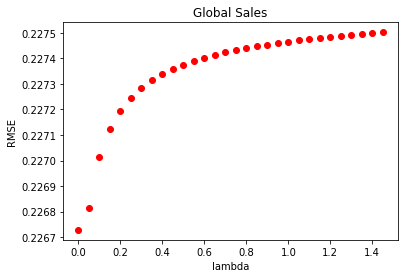

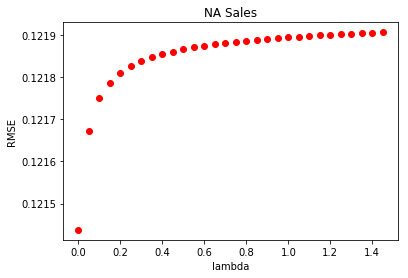

In [34]:
# Hyperparametre 3 (Global_Sales) - parametre de penalisation
nbr_ite = 30

best_RMSE = 1
best_l1 = 0
rmse1 = np.zeros(nbr_ite)

maxY = np.max(Y1)

for i in range(nbr_ite):
    
    # On met a jour l'hyperparametre
    minl = 0.05*i
    
    # On calcule la regression
    B, Y_est = ridge_regression(Y1,X_train_std,minl,best_minY1,best_maxY1)
    
    # On calcule notre erreur
    rmse = RMSE(Y1,Y_est)
    rmse1[i] = rmse
    
    if(rmse < best_RMSE):
        best_RMSE = rmse
        best_l1 = minl

        
print("Global Sales, minl = %.4f" % best_l1)
print("Global Sales, RMSE = %.4f \n" % best_RMSE)


# Hyperparametre 1 (NA_Sales) - parametre de penalisation
best_RMSE = 1
best_l2 = 0
rmse2 = np.zeros(nbr_ite)

maxY = np.max(Y2)

for i in range(nbr_ite):
    
    # On met a jour l'hyperparametre
    minl = 0.05*i
    
    # On calcule la regression
    B, Y_est = ridge_regression(Y2,X_train_std,minl,best_minY2,best_maxY2)
    
    # On calcule notre erreur
    rmse = RMSE(Y2,Y_est)
    rmse2[i] = rmse
    
    if(rmse < best_RMSE):
        best_RMSE = rmse
        best_l2 = minl

        
print("NA Sales, minl = %.4f" % best_l2)
print("NA Sales, RMSE = %.4f \n" % best_RMSE)

index = np.array(list(range(nbr_ite)))
index = index*0.05

plt.plot(index, rmse1, 'or')
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('Global Sales')
plt.show()

plt.plot(index, rmse2, 'or')
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('NA Sales')
plt.show()

In [27]:
# Global Sales
B1, Y_est1 = ridge_regression(Y1,X_train_std,0.5,best_minY1,best_maxY1)

# Clip
global_data = np.dot(X_train_std,np.delete(B1,0)) + B1[0]
global_data = global_data.clip(best_minY1,best_maxY1)

print("R2_prev : ",R2_prev(Y1,global_data,X_train_std))
print("RMSE : ",RMSE(Y1,global_data))

R2_prev :  -48.34795823538862
RMSE :  0.22737505147828263


In [28]:
"""
l = 0.02
R2_prev :  -48.347817314184816
RMSE :  0.22650613448763485
"""

np.max(B1)

0.9029198766016137

In [29]:
# NA Sales
B2, Y_est2 = ridge_regression(Y2,X_train_std,0.5,best_minY2,best_maxY2)

# Clip
na_data = np.dot(X_train_std,np.delete(B2,0)) + B2[0]
na_data = na_data.clip(best_minY2,best_maxY2)

print("R2_prev : ",R2_prev(Y2,na_data,X_train_std))
print("RMSE : ",RMSE(Y2,na_data))

R2_prev :  -53.111878455682024
RMSE :  0.12186633950757095


In [30]:
"""
l = 0.02
R2_prev :  -53.112553000119576
RMSE :  0.1215303737240002
"""

np.max(B2)

0.6592009350166297

In [31]:
"""

Processing du jeu de donnees test

"""

# On genere nos predictions
global_data_test = np.dot(X_test_std,np.delete(B1,0)) + B1[0]
na_data_test = np.dot(X_test_std,np.delete(B2,0)) + B2[0]

# On enleve les valeurs negatives
global_data_test = global_data_test.clip(best_minY1,best_maxY1)  

# On enleve les valeurs negatives
na_data_test = na_data_test.clip(best_minY2,best_maxY2)

# On vient prendre le dataframe comme canva
df_test_estimated = pd.DataFrame([df_test.NA_Sales,df_test.Global_Sales]).copy().T

# On assigne nos predictions aux colonnes
df_test_estimated['Global_Sales'] = global_data_test
df_test_estimated['NA_Sales'] = na_data_test

# On sauvegarde nos predictions
df_test_estimated.to_csv("test_final.csv")